### This script runs MAVE-NN using mutated sequences as input and our DNN model outputs as oracle.  It inherits parts of code from [the tutorials of MAVE-NN](https://github.com/jbkinney/mavenn/tree/master/mavenn/examples/tutorials)

In [ ]:
import os, pickle
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import mavenn
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import logomaker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec



import tensorflow as tf


gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')

GPU_number = 0
if gpus:
    try:
        tf.config.set_visible_devices([gpus[GPU_number]] + cpus, None)
        print(f"Using GPU: {gpus[GPU_number]} and CPU devices")
        
        tf.config.experimental.set_memory_growth(gpus[GPU_number], True)
    except RuntimeError as e:
        print(e)
        


seed_value = 42

random.seed(seed_value)
rng = np.random.default_rng(seed=42)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)


os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(seed_value)



##### Before Running the next cell, one must ensure to run the script in utils: inference_mavenn_oracle.py with same **model_name**, **number_mutated** and **mutation_rate**. Since the script involves an inference step using our models, that needs to be run in an environment with **Pytorch**. On the other hand, MAVE-NN uses **Tensorflow**, hence this script runs on another environment.

In [14]:
model_name = "RNN"
number_mutated = 1000000 # Number of mutated sequences per original sequence
mutation_rate = 0.1 # Mutation rate is the probability of mutating a single nucleotide in a sequence
class_= 2 # Class (1 = Type I, 2 = Type II, 3 = Type III, 4 = Type IV)
number_for_training = 100000
path_premavenn_sequences = Path("results/premavenn") / f"mutations_{model_name}_mutation_rate_{mutation_rate}_number_mutated_{number_mutated}"
if not path_premavenn_sequences.exists():
    raise FileNotFoundError(f"Path {path_premavenn_sequences} does not exist. Please run utils/inference_mavenn_oracle.py first.")
    
with open(path_premavenn_sequences / "inference_results.pickle", "rb") as f:
    results_inference = pickle.load(f)

all_seqs = results_inference["seqs"]
all_probs = results_inference["all_probs"]
all_labels = results_inference["all_labels"]

mask = all_labels == class_
probs = all_probs[mask][:,class_]
seqs = all_seqs[mask]
seqs = np.where(seqs == "T", "U", seqs)

# -----------------------------------------------------------
# 0.  prerequisites: probs (N,), seqs (N,), rng, number_for_training
# -----------------------------------------------------------

edges  = np.arange(0.0, 1.0001, 0.05)          # 0.00 … 1.00  (21 edges → 20 bins)
bin_id = np.digitize(probs, edges, right=False) - 1          # integers 0‥19

# group indices by bin (one sort)
order   = np.argsort(bin_id)
split   = np.flatnonzero(np.diff(bin_id[order])) + 1
bins    = np.split(order, split)
bins    = [b for b in bins if b.size]          # drop empty bins

# -----------------------------------------------------------
# 1.  first pass – give everyone its base share q (+1 for the first r bins)
# -----------------------------------------------------------
q, r        = divmod(number_for_training, len(bins))
take        = np.full(len(bins), q, dtype=int)
take[:r]   += 1                                # the remainder

# cap by actual bin sizes and keep track of what we still need
cap         = np.fromiter((len(b) for b in bins), dtype=int)
take        = np.minimum(take, cap)
need_more   = number_for_training - take.sum()

# -----------------------------------------------------------
# 2.  second pass – distribute the leftovers to bins with room left
# -----------------------------------------------------------
while need_more > 0:
    room      = cap - take                     # how many each bin could still give
    candidates = np.flatnonzero(room)          # bins that still have material
    if not candidates.size:                    # all bins exhausted
        break
    add_here  = rng.choice(candidates, size=min(need_more, candidates.size), replace=False)
    take[add_here] += 1
    need_more = number_for_training - take.sum()

# -----------------------------------------------------------
# 3.  actually draw the indices
# -----------------------------------------------------------
picked = np.concatenate([
    rng.choice(b, size=k, replace=False) for b, k in zip(bins, take) if k > 0
])

seqs  = seqs [picked]
probs = probs[picked]



seqs = ["".join(seq) for seq in seqs]
seqs = np.array(seqs)




#create 10% for testing
test_size = int(len(seqs) * 0.1)
test_indices = np.random.choice(len(seqs), size=test_size, replace=False)
test_mask = np.zeros(len(seqs))
test_mask[test_indices] = 1
test_mask = test_mask.astype(bool)
test_seqs = seqs[test_mask]
test_probs = probs[test_mask]

train_val_seqs = seqs[~test_mask]
train_val_probs = probs[~test_mask]

#split train and validation
val_size = int(len(train_val_seqs) * 0.1)
val_indices = np.random.choice(len(train_val_seqs), size=val_size, replace=False)
val_truth = np.zeros(len(train_val_seqs))
val_truth[val_indices] = 1
val_truth = val_truth.astype(bool)

Text(0.5, 1.0, 'Distribution of probabilities in training and validation set')

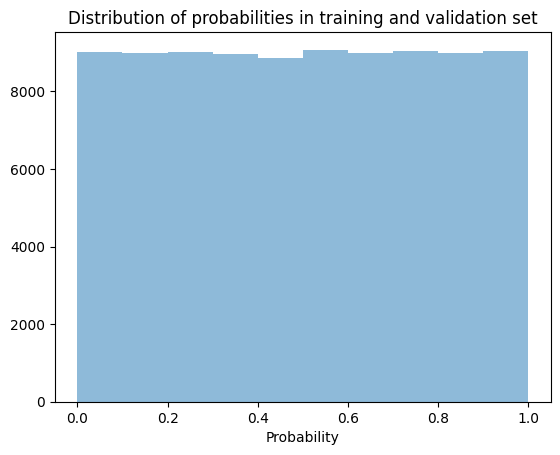

In [7]:
plt.hist(train_val_probs, bins=10, alpha=0.5)
plt.xlabel("Probability")
plt.title("Distribution of probabilities in training and validation set")

### The following create the MAVE-NN model and set the dataset

In [6]:
L = 51 # Length of the sequences to be used in the model
# Define model
model = mavenn.Model(L=L,
                     alphabet='rna',
                     gpmap_type='pairwise',   
                     regression_type='GE',
                     ge_noise_model_type='SkewedT', #"Gaussian", "Cauchy", or "SkewedT"
                     ge_nonlinearity_type = "nonlinear", #['linear', 'nonlinear']
                     ge_heteroskedasticity_order=2,)

# Set training data
model.set_data(x=train_val_seqs,
               y=train_val_probs,
               validation_flags=val_truth)



N = 90,000 observations set as training data.
Using 10.0% for validation.
Data shuffled.
Time to set data: 0.617 sec.


### Now we are ready to fit the model and finally save it

In [ ]:
model.fit(learning_rate=1e-4,
          epochs=100,
          batch_size=64,
          early_stopping=True,
          early_stopping_patience=10,
          restore_best_weights=True,
          verbose=False)


path_mave_results = Path("results/mavenn") 
path_mave_results.mkdir(parents=True, exist_ok=True)
path_run = path_mave_results / f"mutations_{model_name}_mutation_rate_{mutation_rate}_number_mutated_{number_mutated}_number_for_training_{number_for_training}_class_{class_}"
# model.save(path_run.__str__(), verbose=False)
np.save((str(path_run) + "_test_seqs.npy"),   test_seqs)
np.save((str(path_run) + "_test_probs.npy"),  test_probs)
# Delete model if it is present in memory
try:
    del model
except:
    pass

### The model can be loaded for downstream analysis

In [ ]:
# Load model from file
path_mave_results = Path("results/mavenn") 
path_run = path_mave_results / f"mutations_{model_name}_mutation_rate_{mutation_rate}_number_mutated_{number_mutated}_number_for_training_{number_for_training}_class_{class_}"

model = mavenn.load(path_run.__str__(), verbose=False)

Loading model results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_1 ...


#### Here we se the loss across epochs 

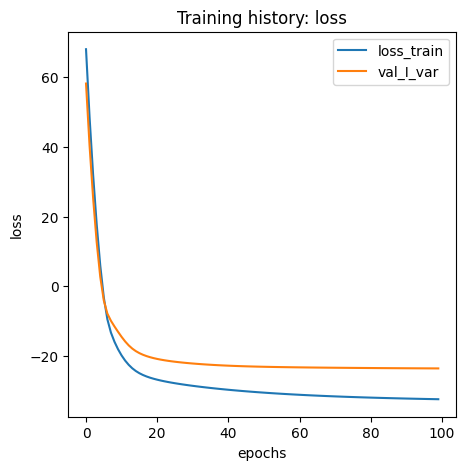

In [175]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Plot loss_train, the loss computed on training data as a function of epoch
ax.plot(model.history['loss'], 
        label=r'loss_train')

# Plot loss_val, the loss computed on validation data as a function of epoch
ax.plot(model.history['val_loss'], 
        label=r'val_I_var')

# Style plot
ax.set_xlabel(r'epochs')
ax.set_ylabel(r'loss')
ax.set_title(r'Training history: loss')
ax.legend()

### Here we can see the correlation between surrogate model and oracle prediction

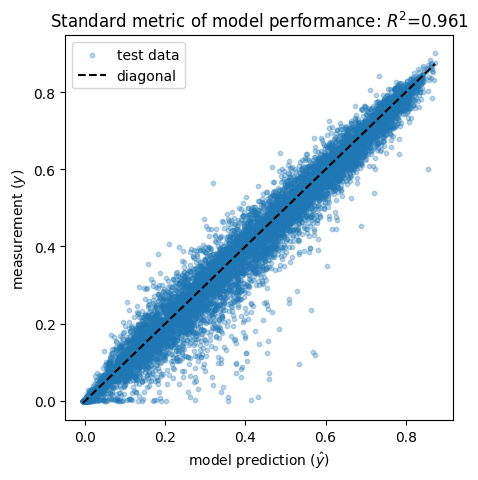

In [176]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Get test data y values
y_test = test_probs

# Compute yhat on test data
yhat_test = model.x_to_yhat(test_seqs)

# Compute R^2 between yhat_test and y_test
Rsq = np.corrcoef(yhat_test.ravel(), test_probs)[0, 1]**2

# Plot y_test vs. yhat_test
ax.scatter(yhat_test, y_test, color='C0', s=10, alpha=.3, 
           label='test data')

# Style plot
xlim = [min(yhat_test), max(yhat_test)]
ax.plot(xlim, xlim, '--', color='k', label='diagonal', zorder=100)
ax.set_xlabel(r'model prediction ($\hat{y}$)')
ax.set_ylabel(r'measurement ($y$)')
ax.set_title(rf'Standard metric of model performance: $R^2$={Rsq:.3}');
ax.legend()

### The following shows the relationship between the measuremente and the latent phenotype

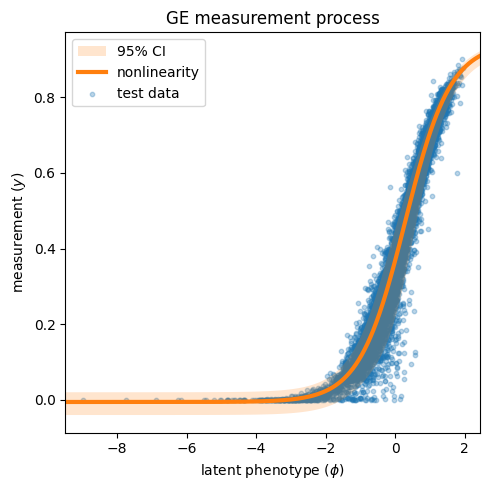

In [165]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Get test data y values
y_test = test_probs

# Compute φ on test data
phi_test = model.x_to_phi(test_seqs)

## Set phi lims and create a grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 95% CI for each yhat
q = [0.025, 0.975]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)


# Plote 95% confidence interval
ax.fill_between(phi_grid, yqs_grid[:, 0], yqs_grid[:, 1],
               alpha=0.2, color='C1', lw=0, label='95% CI')

# Plot GE nonlinearity
ax.plot(phi_grid, yhat_grid, 
        linewidth=3, color='C1', label='nonlinearity')

# Plot scatter of φ and y values,
ax.scatter(phi_test, y_test,
           color='C0', s=10, alpha=.3, label='test data',
           zorder=-100, rasterized=True)

# Style plot
ax.set_xlim(phi_lim)
ax.set_xlabel(r'latent phenotype ($\phi$)')
ax.set_ylabel(r'measurement ($y$)')
ax.set_title(r'GE measurement process')
ax.legend()
fig.tight_layout()

### We finally plot the mutational effect (the weights of the surrogate model). We start with the additive parameters for each base and for each sequence position (4 x 51)

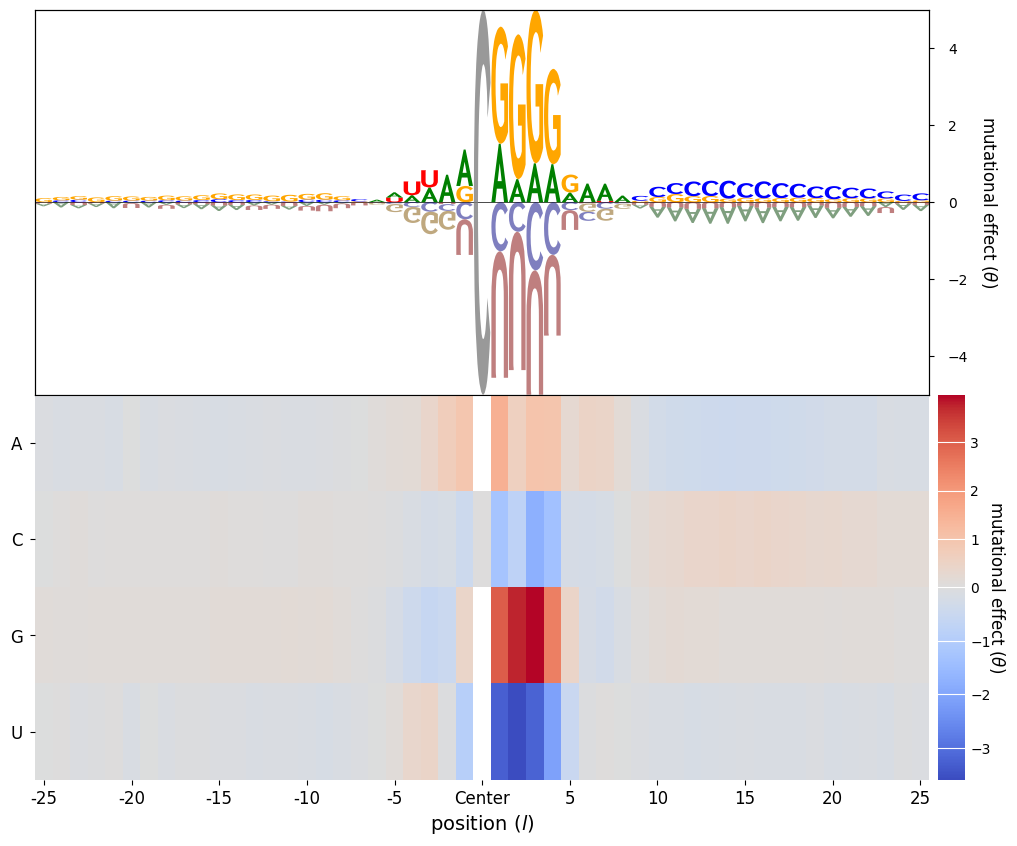

In [167]:
theta_dict = model.get_theta(gauge='uniform',)


fig = plt.figure(figsize=(12, 10))

# Create grid specification that manages the layout
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 0.6], height_ratios=[1, 1], hspace=0.0, wspace=0.02)

# Create the three axes we need with specific positions
ax1 = fig.add_subplot(gs[0, 0])  # Top left - logo
ax2 = fig.add_subplot(gs[1, 0])  # Bottom left - heatmap
cax = fig.add_subplot(gs[1, 1])  # Bottom right - colorbar

# Draw heatmap in bottom plot - pass the pre-created colorbar axis
heatmap_ax, cb = mavenn.heatmap(ax=ax2,
                             values=theta_dict['theta_lc'],
                             alphabet=theta_dict['alphabet'],
                             cmap='coolwarm',
                             cbar=True,
                             cax=cax,   # Pass the pre-created colorbar axis here
                             ccenter=0)

# Style heatmap
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel(r'position ($l$)', fontsize=14)
heatmap_ax.set_xticks(np.arange(0, 51, 5))
tick_labels = [str(i) for i in np.arange(-25, 26, 5)]
tick_labels[len(tick_labels)//2] = "Center"
heatmap_ax.set_xticklabels(tick_labels, fontsize= 12)


alphabet = ["A", "C", "G", "U"]
heatmap_ax.set_yticklabels(alphabet, ha='center', fontsize=12)

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label(r'mutational effect ($\theta$)', labelpad=5, rotation=-90, ha='center', va='center', fontsize=12)

# Create logo plot in top plot
pwm = pd.DataFrame(theta_dict['theta_lc'], columns=["A","C","G","U"])
pwm.fillna(0, inplace=True)  
logo = logomaker.Logo(pwm, ax=ax1, font_name='inconsolata', shade_below=.5, fade_below=.5)
ylim = ax1.get_ylim()
logo.style_single_glyph(p=25, c='C', color='gray', zorder=30, alpha=0.8, floor=ylim[0], ceiling=ylim[1],)
ax1.set_xticks([])
ax1.set_yticks([])


# Create a twin axis on the right side of the top plot
ax_right = ax1.twinx()
ax_right.set_ylim(ylim)
ax_right.set_ylabel(r'mutational effect ($\theta$)', rotation=-90, labelpad=15, ha='center', va='center', fontsize=12)
ax_right.tick_params(axis='y', direction='out', pad=10)




### Now, since we used a pairwise model, we can also check the weights of the surrogate model for pairwise interactions

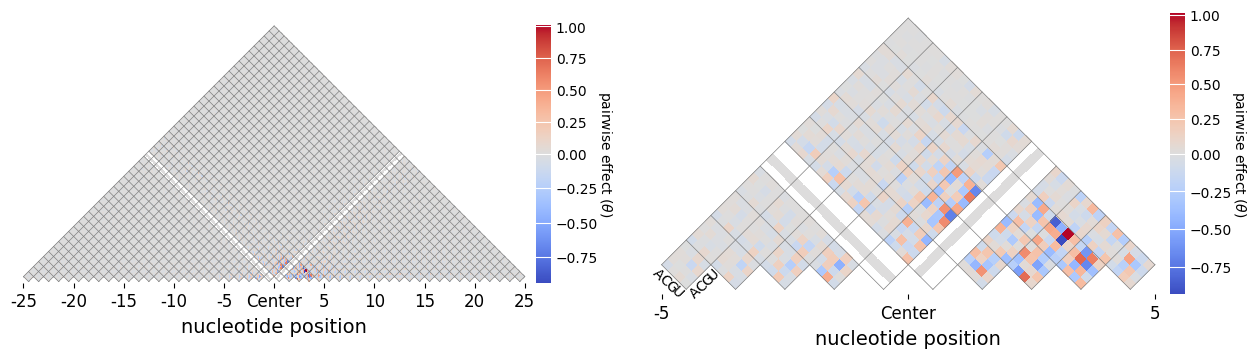

In [168]:
# Get pairwise parameters from theta_dict
theta_lclc = theta_dict['theta_lclc']
seq_len = 51
# Create fig and ax objects
fig, axes = plt.subplots(ncols= 2, figsize=[15,10])
ax = axes[0]
# Draw heatmap
ax, cb = mavenn.heatmap_pairwise(values=theta_lclc,
                                alphabet='rna',
                                ax=ax,
                                gpmap_type='pairwise',
                                cmap_size='3%',
                                show_alphabet=False)

# Style heatmap
ax.set_xticks(np.arange(0, 51, 5))
# ax.set_xticklabels([f'{x:+d}' for x in range(-3,7) if x!=0])
ax.set_xlabel(r'nucleotide position', labelpad=5, fontsize=14)
ax.set_xticks(np.arange(0, 51, 5))
tick_labels = [str(i) for i in np.arange(-25, 26, 5)]
tick_labels[len(tick_labels)//2] = "Center"
ax.set_xticklabels(tick_labels, fontsize= 12)


# Style colorbar
cb.set_label(r'pairwise effect ($\theta$)',
            labelpad=5, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')

ax = axes[1]
theta_lclc = theta_dict['theta_lclc'][seq_len//2-5:seq_len//2+6,:, seq_len//2-5:seq_len//2+6, :]

ax, cb = mavenn.heatmap_pairwise(values=theta_lclc,
                                alphabet='rna',
                                ax=ax,
                                gpmap_type='pairwise',
                                cmap_size='3%',)


ax.set_xlabel(r'nucleotide position', labelpad=5, fontsize=14)
ax.set_xticks(np.arange(0, 11, 5))
tick_labels = [str(i) for i in np.arange(-5, 6, 5)]
tick_labels[len(tick_labels)//2] = "Center"
ax.set_xticklabels(tick_labels, fontsize= 12)


# Style colorbar
cb.set_label(r'pairwise effect ($\theta$)',
            labelpad=5, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')


### The following part is for plots of the article

In [1]:
# Addittive effects

import logomaker
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mavenn
from pathlib import Path

path_4 = Path("results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_4")
path_3 = Path("results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_3")
path_2 = Path("results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_2")
path_1 = Path("results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_1")

# Create the main figure
fig = plt.figure(figsize=(20, 18))  # Larger figure to fit 4 subplots

# Create the outer 2x2 grid
outer_grid = gridspec.GridSpec(2, 2, wspace=0.15, hspace=0.15)

# List of model paths and their labels
model_paths = [path_1, path_2, path_3, path_4]
model_labels = ["Type I", "Type II", "Type III", "Type IV"]


2025-08-26 13:14:44.762189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756214084.774346 1112504 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756214084.778020 1112504 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756214084.788922 1112504 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756214084.788932 1112504 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756214084.788934 1112504 computation_placer.cc:177] computation placer alr

<Figure size 2000x1800 with 0 Axes>

In [ ]:

# Loop through each cell in the 2x2 grid
for i, (model_path, model_label) in enumerate(zip(model_paths, model_labels)):
    # Get row and column position in the outer grid
    row, col = divmod(i, 2)
    
    # Create nested GridSpec for this cell
    inner_grid = gridspec.GridSpecFromSubplotSpec(
        2, 2,  # 2x2 grid for logo and heatmap with colorbar
        subplot_spec=outer_grid[row, col],
        width_ratios=[20, 0.6],  # Same width ratio as original
        height_ratios=[1, 1],     # Same height ratio as original
        wspace=0.02, hspace=0.0   # Same spacing as original
    )
    
    # Load the model for this cell
    model = mavenn.load(model_path.__str__(), verbose=False)
    theta_dict = model.get_theta(gauge='uniform')
    
    # Create axes for this subplot
    ax1 = fig.add_subplot(inner_grid[0, 0])  # Top left - logo
    ax2 = fig.add_subplot(inner_grid[1, 0])  # Bottom left - heatmap
    cax = fig.add_subplot(inner_grid[1, 1])  # Bottom right - colorbar
    
    # Draw heatmap
    heatmap_ax, cb = mavenn.heatmap(ax=ax2,
                                 values=theta_dict['theta_lc'],
                                 alphabet=theta_dict['alphabet'],
                                 cmap='coolwarm',
                                 cbar=True,
                                 cax=cax,
                                 ccenter=0)
    
    # Style heatmap
    heatmap_ax.tick_params(axis='y', which='major', pad=10)
    heatmap_ax.set_xlabel(r'position ($l$)', fontsize=12)
    heatmap_ax.set_xticks(np.arange(0, 51, 5))
    tick_labels = [str(i) for i in np.arange(-25, 26, 5)]
    tick_labels[len(tick_labels)//2] = "Center"
    heatmap_ax.set_xticklabels(tick_labels, fontsize= 12)
    
    alphabet = ["A", "C", "G", "U"]
    heatmap_ax.set_yticklabels(alphabet, ha='center', fontsize=10)
    
    # Style colorbar
    cb.outline.set_visible(False)
    cb.ax.tick_params(direction='in', size=20, color='white')
    cb.set_label(r'mutational effect ($\theta$)', 
               labelpad=5, rotation=-90, ha='center', va='center', fontsize=10)
    
    # Create logo plot
    pwm = pd.DataFrame(theta_dict['theta_lc'], columns=["A","C","G","U"])
    pwm.fillna(0, inplace=True)
    logo = logomaker.Logo(pwm, ax=ax1, font_name='inconsolata', 
                        shade_below=.5, fade_below=.5)
    
    # Add model type label
    ax1.set_title(model_label, fontsize=18, pad=10, loc='center')
    
    # Style logo
    ylim = ax1.get_ylim()
    logo.style_single_glyph(p=25, c='C', color='gray', zorder=30, 
                          alpha=0.8, floor=ylim[0], ceiling=ylim[1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)  # Remove border
    
    # Create twin axis for y-label
    ax_right = ax1.twinx()
    ax_right.set_ylim(ylim)
    ax_right.set_ylabel(r'mutational effect ($\theta$)', 
                      rotation=-90, labelpad=15, ha='center', va='center', fontsize=10)
    ax_right.tick_params(axis='y', direction='out', pad=10)
    
    # Clean up memory
    del model


# plt.savefig("results/mavenn/four_models_additive_effects.pdf", bbox_inches='tight')
plt.savefig("results/mavenn/four_models_additive_effects.eps", bbox_inches='tight')


In [ ]:
# Addittive effects

import logomaker
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mavenn

path_4 = Path("results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_4")
path_3 = Path("results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_3")
path_2 = Path("results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_2")
path_1 = Path("results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_1")

# Create the main figure
fig = plt.figure(figsize=(20, 18))  # Larger figure to fit 4 subplots

# Create the outer 2x2 grid
outer_grid = gridspec.GridSpec(2, 2, wspace=0.15, hspace=0.15)

# List of model paths and their labels
model_paths = [path_1, path_2, path_3, path_4]
model_labels = ["Type I", "Type II", "Type III", "Type IV"]

# Loop through each cell in the 2x2 grid
for i, (model_path, model_label) in enumerate(zip(model_paths, model_labels)):
    # Get row and column position in the outer grid
    row, col = divmod(i, 2)
    
    # Create nested GridSpec for this cell
    inner_grid = gridspec.GridSpecFromSubplotSpec(
        2, 2,  # 2x2 grid for logo and heatmap with colorbar
        subplot_spec=outer_grid[row, col],
        width_ratios=[20, 0.6],  # Same width ratio as original
        height_ratios=[1, 1],     # Same height ratio as original
        wspace=0.02, hspace=0.0   # Same spacing as original
    )
    
    # Load the model for this cell
    model = mavenn.load(model_path.__str__(), verbose=False)
    theta_dict = model.get_theta(gauge='uniform')
    
    # Create axes for this subplot
    ax1 = fig.add_subplot(inner_grid[0, 0])  # Top left - logo
    ax2 = fig.add_subplot(inner_grid[1, 0])  # Bottom left - heatmap
    cax = fig.add_subplot(inner_grid[1, 1])  # Bottom right - colorbar
    
    # Draw heatmap
    heatmap_ax, cb = mavenn.heatmap(ax=ax2,
                                 values=theta_dict['theta_lc'],
                                 alphabet=theta_dict['alphabet'],
                                 cmap='coolwarm',
                                 cbar=True,
                                 cax=cax,
                                 ccenter=0)
    
    # Style heatmap
    heatmap_ax.tick_params(axis='y', which='major', pad=10)
    heatmap_ax.set_xlabel(r'position ($l$)', fontsize=12)
    heatmap_ax.set_xticks(np.arange(0, 51, 5))
    tick_labels = [str(i) for i in np.arange(-25, 26, 5)]
    tick_labels[len(tick_labels)//2] = "Center"
    heatmap_ax.set_xticklabels(tick_labels, fontsize= 12)
    
    alphabet = ["A", "C", "G", "U"]
    heatmap_ax.set_yticklabels(alphabet, ha='center', fontsize=10)
    
    # Style colorbar
    cb.outline.set_visible(False)
    cb.ax.tick_params(direction='in', size=20, color='white')
    cb.set_label(r'mutational effect ($\theta$)', 
               labelpad=5, rotation=-90, ha='center', va='center', fontsize=10)
    
    # Create logo plot
    pwm = pd.DataFrame(theta_dict['theta_lc'], columns=["A","C","G","U"])
    pwm.fillna(0, inplace=True)
    logo = logomaker.Logo(pwm, ax=ax1, font_name='inconsolata', 
                        shade_below=.5, fade_below=.5)
    
    # Add model type label
    ax1.set_title(model_label, fontsize=18, pad=10, loc='center')
    
    # Style logo
    ylim = ax1.get_ylim()
    logo.style_single_glyph(p=25, c='C', color='gray', zorder=30, 
                          alpha=0.8, floor=ylim[0], ceiling=ylim[1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)  # Remove border
    
    # Create twin axis for y-label
    ax_right = ax1.twinx()
    ax_right.set_ylim(ylim)
    ax_right.set_ylabel(r'mutational effect ($\theta$)', 
                      rotation=-90, labelpad=15, ha='center', va='center', fontsize=10)
    ax_right.tick_params(axis='y', direction='out', pad=10)
    
    # Clean up memory
    del model


# plt.savefig("results/mavenn/four_models_additive_effects.pdf", bbox_inches='tight')
# plt.savefig("results/mavenn/four_models_additive_effects.eps", bbox_inches='tight')


Loading model results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_1 ...
Loading model results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_2 ...
Loading model results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_3 ...
Loading model results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_4 ...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


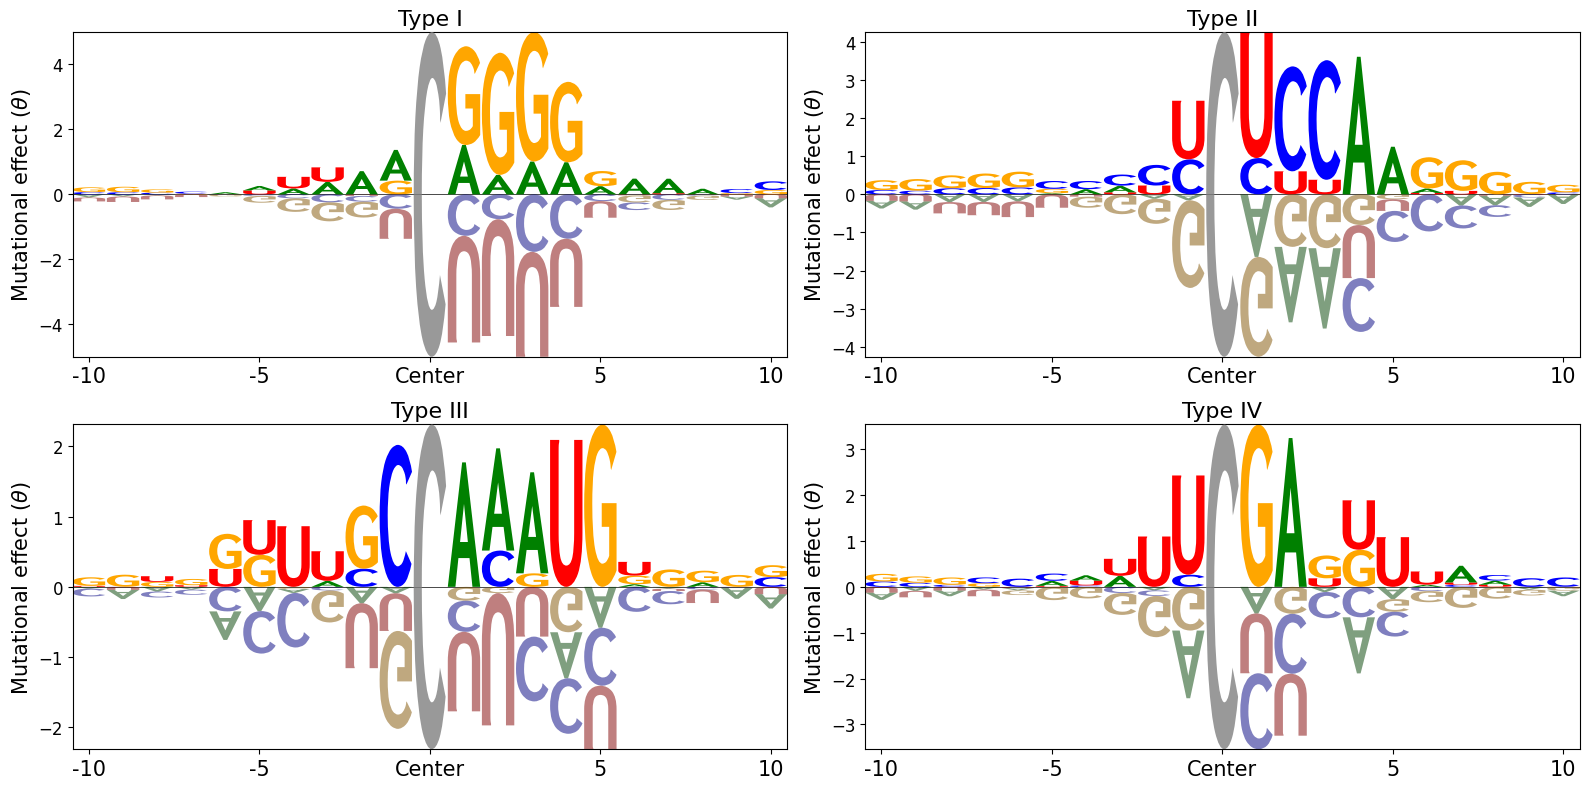

In [10]:
# Additive effects - Logo plots only

import logomaker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mavenn

path_4 = Path("results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_4")
path_3 = Path("results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_3")
path_2 = Path("results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_2")
path_1 = Path("results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_1")

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# List of model paths and their labels
model_paths = [path_1, path_2, path_3, path_4]
model_labels = ["Type I", "Type II", "Type III", "Type IV"]

# Loop through each subplot
for i, (model_path, model_label) in enumerate(zip(model_paths, model_labels)):
    # Get row and column position
    row, col = divmod(i, 2)
    ax = axes[row, col]
    
    # Load the model
    model = mavenn.load(model_path.__str__(), verbose=False)
    theta_dict = model.get_theta(gauge='uniform')
    
    # Create logo plot
    pwm = pd.DataFrame(theta_dict['theta_lc'], columns=["A","C","G","U"])
    pwm.fillna(0, inplace=True)
    pwm = pwm[15:51-15]
    pwm.reset_index(drop=True, inplace=True)
    logo = logomaker.Logo(pwm, ax=ax, font_name='inconsolata', 
                        shade_below=.5, fade_below=.5)
    
    # Add model type label
    ax.set_title(model_label, fontsize=16, pad=5, loc='center')
    
    # Style logo
    ylim = ax.get_ylim()
    # logo.style_single_glyph(p=25, c='C', color='gray', zorder=30, 
    #                       alpha=0.8, floor=ylim[0], ceiling=ylim[1])
    logo.style_single_glyph(p=10, c='C', color='gray', zorder=30, 
                          alpha=0.8, floor=ylim[0], ceiling=ylim[1])
    
    # Add x-axis labels for position
    # ax.set_xticks(np.arange(0, 51, 5))
    # tick_labels = [str(i) for i in np.arange(-25, 26, 5)]
    ax.set_xticks(np.arange(0, 21, 5))
    tick_labels = [str(i) for i in np.arange(-10, 11, 5)]
    tick_labels[len(tick_labels)//2] = "Center"
    ax.set_xticklabels(tick_labels, fontsize=15)
    
    # Add y-axis label
    ax.set_ylabel(r'Mutational effect ($\theta$)', fontsize=15)
    ax.tick_params(axis='y', labelsize=12)

    # Clean up memory
    del model

plt.tight_layout()
plt.savefig("results/mavenn/four_models_logos_only.pdf", bbox_inches='tight')
plt.savefig("results/mavenn/four_models_logos_only.eps", bbox_inches='tight')
# plt.show()

In [ ]:
#pairwise effects
fig, axes = plt.subplots(nrows= 4, ncols = 2, figsize=[15,20], tight_layout=True)


fig.subplots_adjust(hspace=0.0, wspace=0.0)


for i, (model_path, model_label) in enumerate(zip(model_paths, model_labels)):

    

    model = mavenn.load(model_path.__str__(), verbose=False)
    theta_dict = model.get_theta(gauge='uniform')

    # Get pairwise parameters from theta_dict
    theta_lclc = theta_dict['theta_lclc']
    seq_len = 51
    # Create fig and ax objects

    ax = axes[i, 0]

    # Draw heatmap
    ax, cb = mavenn.heatmap_pairwise(values=theta_lclc,
                                    alphabet='rna',
                                    ax=ax,
                                    gpmap_type='pairwise',
                                    cmap_size='3%',
                                    show_alphabet=False,
                                    # clim = [-2, 2]
                                    )

    # Style heatmap
    ax.set_xticks(np.arange(0, 51, 5))
    # ax.set_xticklabels([f'{x:+d}' for x in range(-3,7) if x!=0])
    ax.set_xlabel(r'nucleotide position', labelpad=5, fontsize=14)
    ax.set_xticks(np.arange(0, 51, 5))
    tick_labels = [str(i) for i in np.arange(-25, 26, 5)]
    tick_labels[len(tick_labels)//2] = "Center"
    ax.set_xticklabels(tick_labels, fontsize= 12)

    ax.set_title(model_label, fontsize=18, pad=10, loc='center')


    # Style colorbar
    cb.set_label(r'pairwise effect ($\theta$)',
                labelpad=5, ha='center', va='center', rotation=-90)
    cb.outline.set_visible(False)
    cb.ax.tick_params(direction='in', size=20, color='white')

    ax = axes[i, 1]
    theta_lclc = theta_dict['theta_lclc'][seq_len//2-5:seq_len//2+6,:, seq_len//2-5:seq_len//2+6, :]

    ax, cb = mavenn.heatmap_pairwise(values=theta_lclc,
                                    alphabet='rna',
                                    ax=ax,
                                    gpmap_type='pairwise',
                                    cmap_size='3%',
                                    # clim = [-2, 2]
                                    )


    ax.set_xlabel(r'nucleotide position', labelpad=5, fontsize=14)
    ax.set_xticks(np.arange(0, 11, 1))
    tick_labels = [str(i) for i in np.arange(-5, 6, 1)]
    tick_labels[len(tick_labels)//2] = "Center"
    ax.set_xticklabels(tick_labels, fontsize= 12)

    ax.set_title(model_label + r" (Center $\pm$ 5)", fontsize=18, pad=10, loc='center')


    # Style colorbar
    cb.set_label(r'pairwise effect ($\theta$)',
                labelpad=5, ha='center', va='center', rotation=-90)
    cb.outline.set_visible(False)
    cb.ax.tick_params(direction='in', size=20, color='white')

# plt.savefig("results/mavenn/four_models_pairwise_effects.pdf", bbox_inches='tight')

In [ ]:
fig_r2, axes_r2 = plt.subplots(2, 2, figsize=(12, 10), tight_layout=True)
fig_ge, axes_ge = plt.subplots(2, 2, figsize=(12, 10), tight_layout=True)

for model_path, cls_label, ax_r2, ax_ge in zip(
        model_paths, model_labels, axes_r2.flat, axes_ge.flat):

    model      = mavenn.load(str(model_path), verbose=False)
    y_true     = np.load((str(model_path) +   '_test_probs.npy'))
    test_seqs  = np.load((str(model_path) + '_test_seqs.npy'), allow_pickle=True)

    # R² panel ---------------------------------------------------------------
    y_pred = model.x_to_yhat(test_seqs).ravel()
    r2     = np.corrcoef(y_pred, y_true)[0, 1]**2
    ax_r2.scatter(y_pred, y_true, s=8, alpha=.3, color='C0')
    lim   = [min(y_pred.min(), y_true.min()), max(y_pred.max(), y_true.max())]
    ax_r2.plot(lim, lim, '--k', lw=1)
    ax_r2.set_xlim(lim); ax_r2.set_ylim(lim)
    ax_r2.set_xlabel(r'$\hat{y}$'); ax_r2.set_ylabel(r'$y$')
    ax_r2.set_title(f'{cls_label}\n$R^2$ = {r2:.3f}')

    # GE-process panel -------------------------------------------------------
    phi     = model.x_to_phi(test_seqs)
    phi_lim = [phi.min()-.5, phi.max()+.5]
    grid    = np.linspace(*phi_lim, 1000)
    yhat    = model.phi_to_yhat(grid)
    yqs     = model.yhat_to_yq(yhat, q=[.025, .975])
    ax_ge.fill_between(grid, yqs[:,0], yqs[:,1], color='C1', alpha=.2)
    ax_ge.plot(grid, yhat, color='C1', lw=2)
    ax_ge.scatter(phi, y_true, s=8, alpha=.3, color='C0', rasterized=True)
    ax_ge.set_xlim(phi_lim)
    ax_ge.set_xlabel(r'latent $\phi$'); ax_ge.set_ylabel(r'$y$')
    ax_ge.set_title(f'{cls_label} – GE process')

    del model                        # free memory

fig_r2.savefig('results/mavenn/four_models_R2_scatter.pdf',  bbox_inches='tight')
fig_ge.savefig('results/mavenn/four_models_GE_process.pdf', bbox_inches='tight')


Loading model results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_1 ...
Loading model results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_2 ...
Loading model results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_3 ...
Loading model results/mavenn/mutations_RNN_mutation_rate_0.1_number_mutated_1000000_number_for_training_100000_class_4 ...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


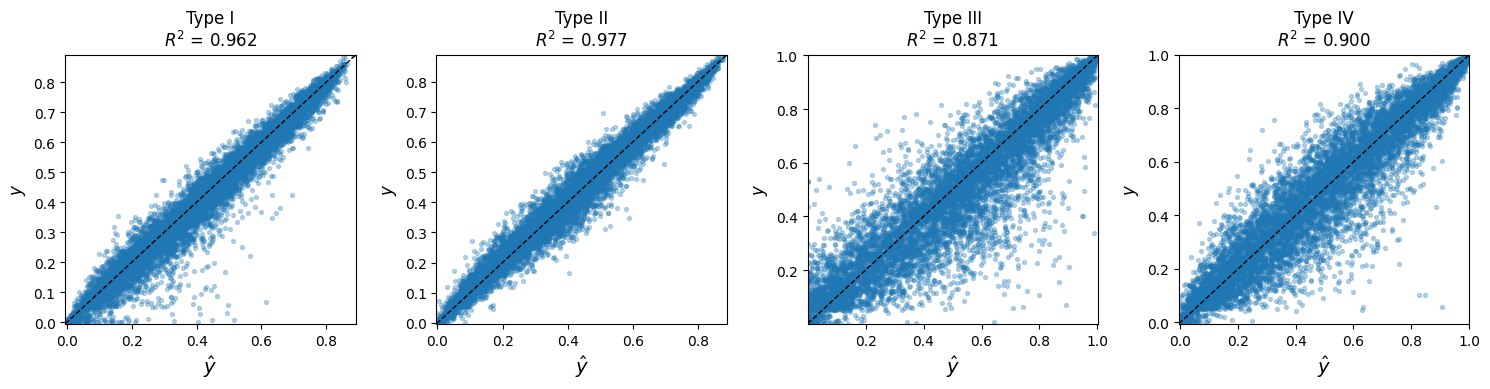

In [18]:
fig_r2, axes_r2 = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)

for model_path, cls_label, ax_r2 in zip(
        model_paths, model_labels, axes_r2.flat):

    model      = mavenn.load(str(model_path), verbose=False)
    y_true     = np.load((str(model_path) +   '_test_probs.npy'))
    test_seqs  = np.load((str(model_path) + '_test_seqs.npy'), allow_pickle=True)

    # R² panel ---------------------------------------------------------------
    y_pred = model.x_to_yhat(test_seqs).ravel()
    r2     = np.corrcoef(y_pred, y_true)[0, 1]**2
    ax_r2.scatter(y_pred, y_true, s=8, alpha=.3, color='C0')
    lim   = [min(y_pred.min(), y_true.min()), max(y_pred.max(), y_true.max())]
    ax_r2.plot(lim, lim, '--k', lw=1)
    ax_r2.set_xlim(lim); ax_r2.set_ylim(lim)
    ax_r2.set_xlabel(r'$\hat{y}$', fontsize=14); ax_r2.set_ylabel(r'$y$', fontsize=12)
    ax_r2.set_title(f'{cls_label}\n$R^2$ = {r2:.3f}')

    del model                        # free memory

# fig_r2.savefig('results/mavenn/four_models_R2_scatter.pdf',  bbox_inches='tight')
fig_r2.savefig('results/mavenn/four_models_R2_scatter.eps',  bbox_inches='tight')

